<a href="https://colab.research.google.com/github/ravindulakshithaperera1995/test_ml_project/blob/develop/An_Approach_for_Crowd_Counting_and_Crowd_Density_Estimation_using_Aerial_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

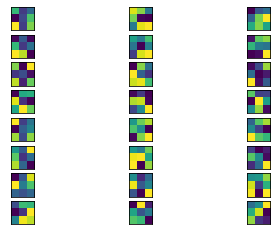

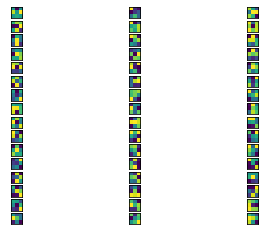

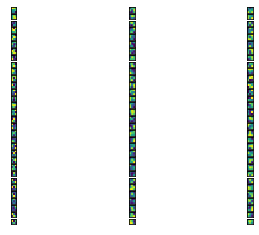

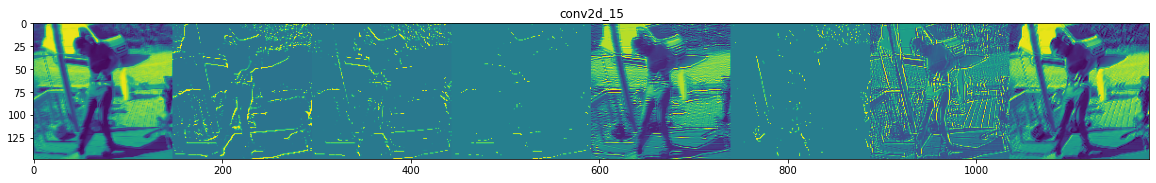

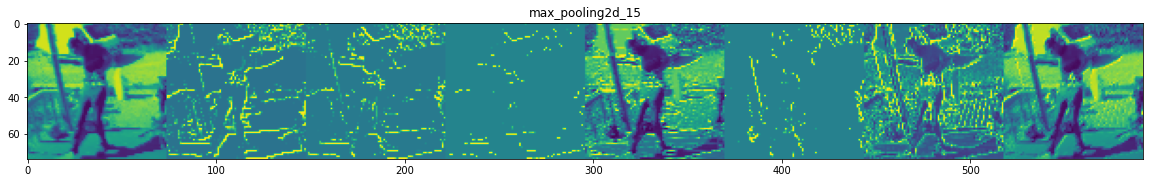

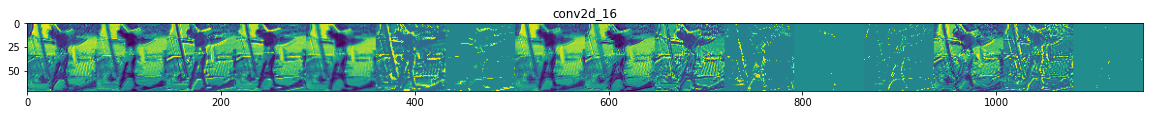

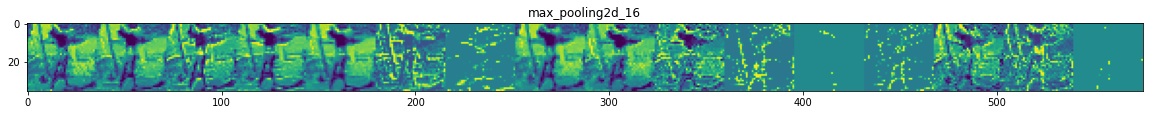

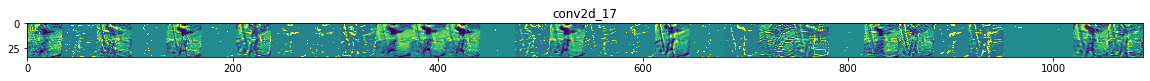

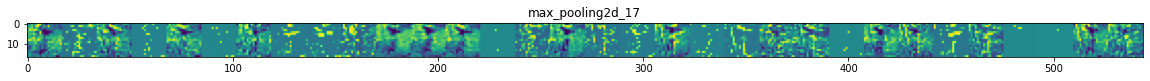

In [6]:
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
import glob
import matplotlib.pyplot as plt
import numpy as np

# 
cnn = models.Sequential([
    layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),

    layers.Dense(1024, activation='relu'),
    layers.Dense(512, activation='relu'),

    layers.Dense(3, activation='sigmoid')
])

cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])   

train_set = []
for filename in glob.glob('/content/drive/MyDrive/human detection dataset/train_set/*.png'): 
    img = keras.utils.load_img(filename, target_size=(150, 150))    
    npy_img = keras.preprocessing.image.img_to_array(img)
    npy_img = npy_img.reshape((1,) + npy_img.shape) 
    npy_img /= 255.0
    train_set.append(npy_img) 

# Create filters
for layer in cnn.layers: 
  if 'conv' in layer.name:
      weights, bias= layer.get_weights()
        
      f_min, f_max = weights.min(), weights.max()
      filters = (weights - f_min) / (f_max - f_min)  
      filter_cnt=1
        
      for i in range(filters.shape[3]):
          filt=filters[:,:,:, i]
          for j in range(filters.shape[0]):
              ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
              ax.set_xticks([])
              ax.set_yticks([])
              plt.imshow(filt[:,:, j])
              filter_cnt+=1
      plt.show()

layer_outputs = [layer.output for layer in cnn.layers]
layer_names = [layer.name for layer in cnn.layers]
feature_map_model = models.Model(cnn.input, layer_outputs)

pathName = '/content/drive/MyDrive/human detection dataset/train_set/1.png'
image = keras.utils.load_img(pathName, target_size=(150, 150))    
img_arr = keras.preprocessing.image.img_to_array(image)
img_arr = img_arr.reshape((1,) + img_arr.shape) 
img_arr /= 255.0   

# Create feature map for the selected image
feature_maps = feature_map_model.predict(img_arr)
for layer_name, feature_map in zip(layer_names, feature_maps):
  if len(feature_map.shape) == 4:
     n_features = feature_map.shape[-1]
     size       = feature_map.shape[ 1]
     display_grid = np.zeros((size, size* n_features))
     
     # Postprocess the feature to be visually palatable
     for i in range(n_features):
       x  = feature_map[0, :, :, i]
       x -= x.mean()
       x /= x.std()
       x *=  64
       x += 128
       x  = np.clip(x, 0, 255).astype('uint8')
       # Tile each filter into a horizontal grid
       display_grid[:, i * size : (i+1) * size] = x
       # Display the grid
     scale = 20. / n_features
     plt.figure( figsize=(scale * n_features, scale) )
     plt.title ( layer_name )
     plt.grid  ( False )
     plt.imshow( display_grid, aspect='auto', cmap='viridis' )